<a href="https://colab.research.google.com/github/HK-Sepuri/HK-Sepuri/blob/main/Fastai/burger_pizza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 16.6 MB/s eta 0:00:00


In [2]:
# from duckduckgo_search import ddg_images
from fastcore.all import *
# Check fastbook is installed
!pip install fastbook
# Import fastbook functions, in our case we'll be using: search_images_ddg
from fastbook import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [3]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [4]:
urls=search_images('burger',max_images=1)
urls[0]

'https://cmx.weightwatchers.com/assets-proxy/weight-watchers/image/upload/v1594406683/visitor-site/prod/ca/burgers_mobile_0_z7ruzb'

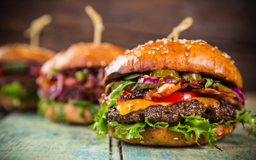

In [5]:
from fastdownload import download_url
dest='burger.jpg'
download_url(urls[0],dest,show_progress=False)

from fastai.vision.all import *
im=Image.open(dest)
im.to_thumb(256,256)

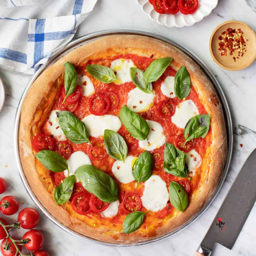

In [6]:
download_url(search_images('pizza',max_images=1)[0],'pizza.jpg',show_progress=False)
Image.open('pizza.jpg').to_thumb(256,256)

In [7]:
searches = 'burger','pizza'
path = Path('burger_or_pizza')
from time import sleep

max_images=100

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo', max_images=max_images))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} cartoon photo', max_images=max_images))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} cheezy photo', max_images=max_images))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

11

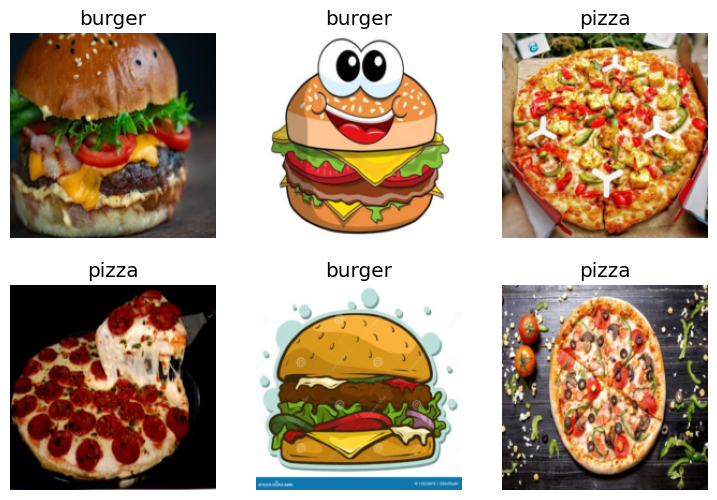

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.632330,0.047107,0.037037,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.067584,0.039754,0.018519,00:02
1,0.046071,0.011459,0.000000,00:03
2,0.029807,0.010480,0.000000,00:02
3,0.024141,0.014587,0.009259,00:02
4,0.022305,0.034464,0.018519,00:02
5,0.021562,0.019820,0.009259,00:02
6,0.017797,0.017187,0.009259,00:03
7,0.015441,0.029988,0.009259,00:02
8,0.011588,0.032096,0.009259,00:02
9,0.010124,0.032786,0.009259,00:02


In [11]:
print('Checking fastfood photo:')
is_burger,_,probs = learn.predict(PILImage.create('burger.jpg'))
print(f"This is a: {is_burger}.")
print(f"Probability it's a burger: {probs[0]:.4f}")
print("\n\n---\n\n")

print('Checking goose photo:')
is_burger,_,probs = learn.predict(PILImage.create('pizza.jpg'))
print(f"This is a: {is_burger}.")
print(f"Probability it's a burger: {probs[0]:.4f}")

Checking fastfood photo:


This is a: burger.
Probability it's a burger: 1.0000


---


Checking goose photo:


This is a: pizza.
Probability it's a burger: 0.0000
